In [1]:
import jax.numpy as jnp
from jax.config import config
config.update('jax_enable_x64', True)

from jax import random, vmap

from jax_md import space, energy, quantity

from common_utils.minimization import run_minimization_scan, run_minimization_scan_neighbor_list
from common_utils.minimization import run_minimization_while, run_minimization_while_neighbor_list
from common_utils.brownian import run_brownian, run_brownian_neighbor_list, run_brownian_neighbor_list_unsafe


import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

f32 = jnp.float32
f64 = jnp.float64

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])

def box_size_at_packing_fraction_2d(phi,diameters):
  Vspheres = jnp.sum(vmap(lambda d: jnp.pi*(d/2)**2)(diameters))
  return (Vspheres/phi)**(0.5)

# Basic Minimization and Brownian Dynamics

Set up system

In [2]:
N = 50
dimension = 2

diameters = jnp.linspace(1.0,1.4,N)
box_size = box_size_at_packing_fraction_2d(0.9, diameters)
displacement, shift = space.periodic(box_size)

energy_fn = energy.soft_sphere_pair(displacement, sigma=diameters)

key = random.PRNGKey(4)
key, split = random.split(key)
R_init = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

Run minimization for fixed number of steps

In [3]:
R_final, maxgrad = run_minimization_scan(energy_fn, R_init, shift, 100)
print('minimization ran for {} steps'.format(100))
print(maxgrad)

minimization ran for 100 steps
0.009193765583207447


Run minimization until a threshold is reached

In [4]:
R_final, maxgrad, i_last = run_minimization_while(energy_fn, R_init, shift)
print('minimization ran for {} steps'.format(i_last))
print(maxgrad)

minimization ran for 800 steps
9.963280200864233e-13


Run a Brownian Dynamics simulation and return the trajectory

In [5]:
key, split = random.split(key)
final_state, trajectory = run_brownian(energy_fn, R_final, shift, split, 
                                       num_total_steps=10000, record_every=100, 
                                       dt=0.0001, kT=0.01, gamma=0.1)
trajectory.shape

(100, 50, 2)

Run a Brownian Dynamics simulation and return the pair correlation function, 𝑔(𝑟), every 100 steps. Plot this.

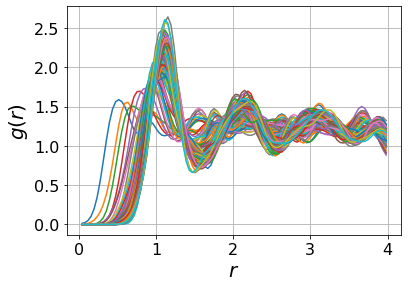

In [6]:
rs = jnp.linspace(0,box_size/2.0, 101)[1:]
g_fn = quantity.pair_correlation(displacement, rs, 0.1)
def measurement(R):
  return jnp.mean(g_fn(R),axis=0)

key, split = random.split(key)
final_state, gofr_all = run_brownian(energy_fn, R_init, shift, split, 
                                     num_total_steps=10000, record_every=100, 
                                     dt=0.0001, measure_fn = measurement,
                                     kT=0.01, gamma=0.1)
for gofr in gofr_all:
  plt.plot(rs,gofr)
format_plot(r'$r$', r'$g(r)$')
finalize_plot()

# Minimization and Brownian Dynamics with neighbor lists

Set up system

In [7]:
N = 5000
dimension = 2

diameters = jnp.linspace(1.0,1.4,N)
box_size = box_size_at_packing_fraction_2d(0.9, diameters)
displacement, shift = space.periodic(box_size)

#energy_fn = energy.soft_sphere_pair(displacement, sigma=diameters)
neighbor_fn, energy_fn = energy.soft_sphere_neighbor_list(
    displacement, box_size, sigma=diameters, dr_threshold = 0.1)

key = random.PRNGKey(4)
key, split = random.split(key)
R_init = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

Construct the neighbor list (this cannot be jitted or differentiated)

In [8]:
nbrs = neighbor_fn(R_init)
nbrs.max_occupancy

20

Run minimization for a fixed number of steps

In [9]:
R_final, maxgrad, new_nbrs = run_minimization_scan_neighbor_list(
    energy_fn, neighbor_fn, nbrs, R_init, shift, num_steps = 6000)
print(new_nbrs.did_buffer_overflow) #Always always check this!!!!! It can fail silently.
print(maxgrad)

False
1.9474281816051625e-09


Run minimization until a threshold is reached

In [10]:
R_final, maxgrad, nbrs_new, niter = run_minimization_while_neighbor_list(
    energy_fn, neighbor_fn, R_init, shift, max_grad_thresh = 1e-12, 
    max_num_steps = 1000000, step_inc = 1000, verbose=True)
print(maxgrad)
print(niter)
print(nbrs.did_buffer_overflow)

minimization step 0
minimization step 1000
minimization step 2000
minimization step 3000
minimization step 4000
minimization step 5000
minimization step 6000
minimization step 7000
successfully finished 8000000 steps.
4.743046233546266e-13
8000
False


Run a unsafe Brownian Dynamics simulation and return the trajectory

In [11]:
key, split = random.split(key)
final_state, trajectory, final_nbrs = run_brownian_neighbor_list_unsafe(
    energy_fn, neighbor_fn, nbrs, R_init, shift, split, num_total_steps = 50000, 
    record_every=1000, dt=0.0001, kT=0.01, gamma=0.1)
if final_nbrs.did_buffer_overflow:
  print('WARNING: buffer overflow') #ALWAYS ALWAYS CHECK THIS!
trajectory.shape

(50, 5000, 2)

Run a unsafe Borwnian Dynamics simulations and return the pair correlation function, 𝑔(𝑟), every 100 steps. Plot this.

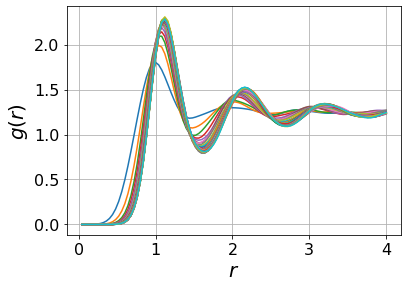

In [12]:
rs = jnp.linspace(0,4.0, 101)[1:]
gnbr_fn, g_fn = quantity.pair_correlation_neighbor_list(displacement, box_size, rs, 0.1)
gnbrs = gnbr_fn(R_init)
def measurement(R,nbrs,gnbrs):
  gnbrs = gnbr_fn(R, gnbrs)
  return jnp.mean(g_fn(R,gnbrs),axis=0)

key, split = random.split(key)
final_state, gofr_all, final_nbrs = run_brownian_neighbor_list_unsafe(
    energy_fn, neighbor_fn, nbrs, R_init, shift, split, num_total_steps = 50000, 
    record_every=1000, dt=0.0001, kT=0.01, gamma=0.1, measure_fn=measurement, gnbrs=gnbrs)
if final_nbrs.did_buffer_overflow:
  print('WARNING: buffer overflow') #ALWAYS ALWAYS CHECK THIS

for gofr in gofr_all:
  plt.plot(rs,gofr)
format_plot(r'$r$', r'$g(r)$')
finalize_plot()

Run a safe Brownian Dynamics simulation and return the trajectory

In [13]:
key, split = random.split(key)
final_state, trajectory, final_nbrs = run_brownian_neighbor_list(
    energy_fn, neighbor_fn, R_init, shift, split, num_steps = 10000, 
    step_inc=1000, dt=0.0001, kT=0.01, gamma=0.1, verbose=True)
if final_nbrs.did_buffer_overflow:
  print('WARNING: buffer overflow')
trajectory.shape

simulation step 0
simulation step 1000
simulation step 2000
simulation step 3000
simulation step 4000
simulation step 5000
simulation step 6000
simulation step 7000
simulation step 8000
simulation step 9000
successfully finished 10000 steps.


(10, 5000, 2)

Run a safe Borwnian Dynamics simulations and return the pair correlation function, 𝑔(𝑟), every 100 steps. Plot this.

simulation step 0
simulation step 1000
simulation step 2000
simulation step 3000
simulation step 4000
simulation step 5000
simulation step 6000
simulation step 7000
simulation step 8000
simulation step 9000
successfully finished 10000 steps.


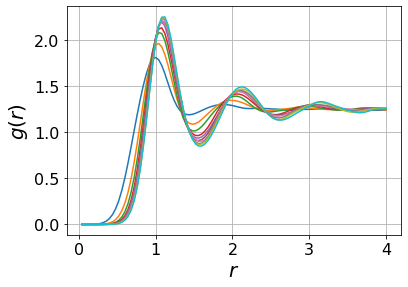

In [14]:
rs = jnp.linspace(0,4.0, 101)[1:]
gnbr_fn, g_fn = quantity.pair_correlation_neighbor_list(displacement, box_size, rs, 0.1)
gnbrs = gnbr_fn(R_init)
def measurement(R,nbrs,gnbrs):
  gnbrs = gnbr_fn(R, gnbrs)
  return jnp.mean(g_fn(R,gnbrs),axis=0)

key, split = random.split(key)
final_state, gofr_all, final_nbrs = run_brownian_neighbor_list(
    energy_fn, neighbor_fn, R_init, shift, split, num_steps = 10000, 
    step_inc=1000, dt=0.0001, kT=0.01, gamma=0.1, verbose=True,
     measure_fn=measurement, gnbrs=gnbrs)
if final_nbrs.did_buffer_overflow:
  print('WARNING: buffer overflow')

for gofr in gofr_all:
  plt.plot(rs,gofr)
format_plot(r'$r$', r'$g(r)$')
finalize_plot()